In [1]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import plotly.graph_objects as go
import os
import random as r
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from CalcMFCC import calculate_mfcc
import InitialParams as ip
import PinkNoise as pn

In [2]:
np.random.seed(42)
r.seed(42)
tf.random.set_seed(42)

In [1]:
def pad_or_truncate_mfcc(mfcc, max_length):
    current_length = mfcc.shape[0]
    if current_length < max_length:
        padding = max_length - current_length
        return np.pad(mfcc, ((0, padding), (0, 0)), mode='constant')
    else:
        return mfcc[:max_length]

def normalize_features(X):
    scaler = StandardScaler()
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_normalized = scaler.fit_transform(X_reshaped).reshape(X.shape)
    return X_normalized, scaler

def prepare_data(audio_files, sample_rate, win_len, hop_len, n_mfcc, max_length, noised=False, intensity = 0.0001):
    mfcc_features = []
    labels = []
    SNR = 0
    label_map = {label: idx for idx, label in enumerate(audio_files.keys())}
    for label, files in audio_files.items():
        for file in files:
            audio = librosa.load(file, sr=sample_rate)[0]
            if noised == True:
                pink_noise = pn.generate_pink_noise(len(audio)) 
                pink_audio = pn.generate_noisy_signal(audio, pink_noise, intensity)
                SNR = 10*np.log(np.sum(np.power(audio, 2))/np.sum(np.power(pink_audio-audio, 2)))
                audio = pink_audio
            mfcc = calculate_mfcc(audio, sample_rate, win_len, hop_len, n_mfcc)
            mfcc = pad_or_truncate_mfcc(mfcc.T, max_length)
            mfcc_features.append(mfcc)
            labels.append(label_map[label])
    
    X = np.array(mfcc_features)
    y = np.array(labels)
    X, scaler = normalize_features(X)
    
    return X, y, scaler, SNR

In [4]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
best_model = None
best_history = None
best_val_accuracy = 0

In [5]:
Soileushiler = {}
for i in range(1, 17):
    Soileushiler[i-1] = [f'DaustarNew/Soyleushy_{i}/' + j for j in os.listdir(f'DaustarNew/Soyleushy_{i}')]

print(f'''Дискреттеу жиілігі: {ip.F_dis} Гц,
MFCC коэффициенттер саны: {ip.n_mfcc},
MFCC фреймінің ұзындығы: {ip.mfcc_frame}''')

X, y, scaler, _ = prepare_data(Soileushiler, ip.F_dis, ip.win_len, ip.hop_len, ip.n_mfcc, ip.mfcc_frame)

Дискреттеу жиілігі: 48000 Гц,
MFCC коэффициенттер саны: 20,
MFCC фреймінің ұзындығы: 170


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Train samples: 153
Test samples: 39


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model():
    temp_model = Sequential([
        Masking(mask_value=0.0, input_shape=(ip.mfcc_frame, ip.n_mfcc)),
        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling1D(pool_size=2),
        Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.1)),
        Dropout(0.5),
        Dense(16, activation='softmax') 
    ])
    temp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return temp_model



In [9]:
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ]
    
    CNNmodel = create_model()
    
    history = CNNmodel.fit(X_train_fold,
                       y_train_fold, epochs=100, batch_size=64, validation_data=(X_val_fold, y_val_fold),
                       callbacks=callbacks)
    
    val_accuracy = max(history.history['val_accuracy'])
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = CNNmodel
        best_history = history

Epoch 1/100
3/3 [==============================] - 1s 158ms/step - loss: 29.0187 - accuracy: 0.0219 - val_loss: 23.7276 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 65ms/step - loss: 22.3539 - accuracy: 0.2847 - val_loss: 18.3473 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 65ms/step - loss: 17.2179 - accuracy: 0.4672 - val_loss: 14.1757 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 69ms/step - loss: 13.1318 - accuracy: 0.6131 - val_loss: 11.1652 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 70ms/step - loss: 10.2540 - accuracy: 0.6204 - val_loss: 8.7581 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 70ms/step - loss: 8.1409 - accuracy: 0.7226 - val_loss: 7.1291 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 0s 70ms/step - loss: 

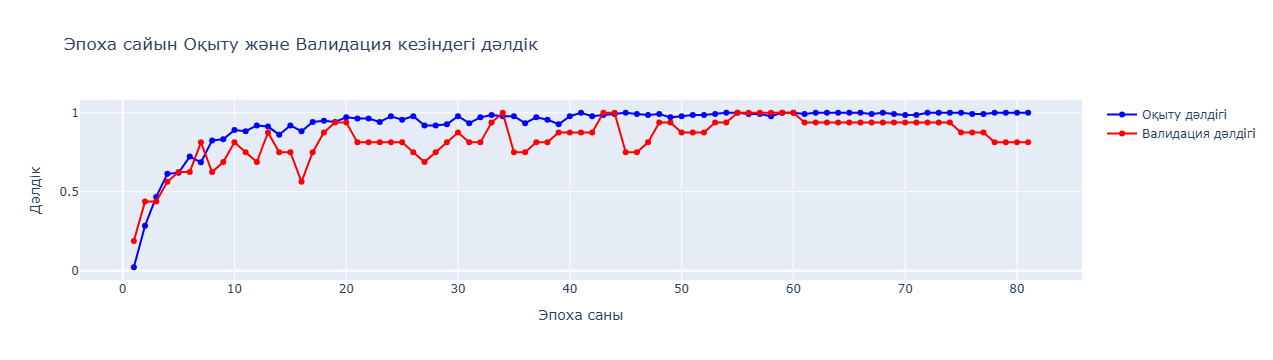

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, len(best_history.history['accuracy']) + 1)),
    y=best_history.history['accuracy'],
    mode='lines+markers',
    name='Оқыту дәлдігі',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=list(range(1, len(best_history.history['val_accuracy']) + 1)),
    y=best_history.history['val_accuracy'],
    mode='lines+markers',
    name='Валидация дәлдігі',
    line=dict(color='red')
))

fig.update_layout(
    title='Эпоха сайын Оқыту және Валидация кезіндегі дәлдік',
    xaxis_title='Эпоха саны',
    yaxis_title='Дәлдік'
)

fig.show()

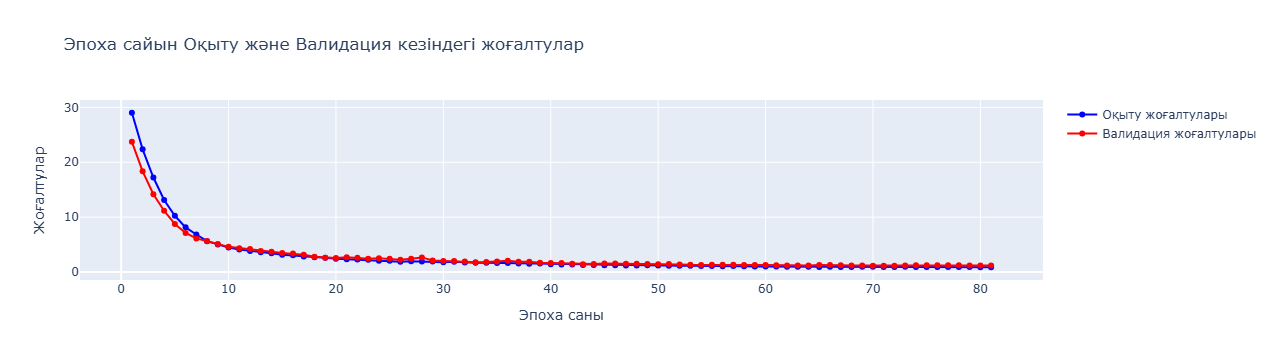

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, len(best_history.history['loss']) + 1)),
    y=best_history.history['loss'],
    mode='lines+markers',
    name='Оқыту жоғалтулары',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=list(range(1, len(best_history.history['val_loss']) + 1)),
    y=best_history.history['val_loss'],
    mode='lines+markers',
    name='Валидация жоғалтулары',
    line=dict(color='red')
))

fig.update_layout(
    title='Эпоха сайын Оқыту және Валидация кезіндегі жоғалтулар',
    xaxis_title='Эпоха саны',
    yaxis_title='Жоғалтулар'
)
fig.show()

In [51]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Тестілік жоғалтулар: {test_loss}, Тестілік дәлдік: {test_accuracy}')

2/2 [==============================] - 0s 9ms/step - loss: 1.1256 - accuracy: 0.9231
Тестілік жоғалтулар: 1.1255934238433838, Тестілік дәлдік: 0.9230769276618958


2/2 [==============================] - 0s 13ms/step


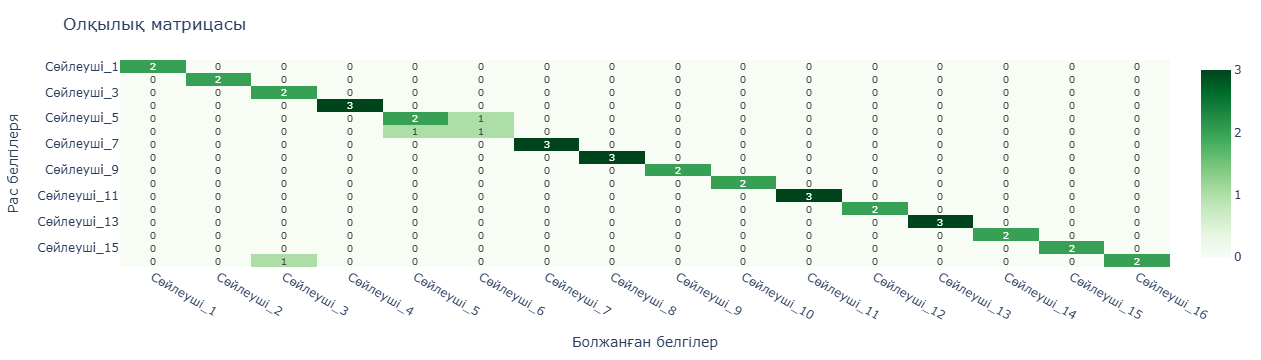

In [13]:
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_pred_probabilities = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=[i for i in range(0, 16)])

xlabels = [f'Сөйлеуші_{i+1}' for i in range(0, 16)]

fig = px.imshow(conf_matrix, x=xlabels, y=xlabels, text_auto='.d', aspect='auto', color_continuous_scale='Greens',\
               labels=dict(x='Болжанған белгілер', y='Рас белгілеря'))
fig.update_layout(title='Олқылық матрицасы')
fig.show()

<Axes: >

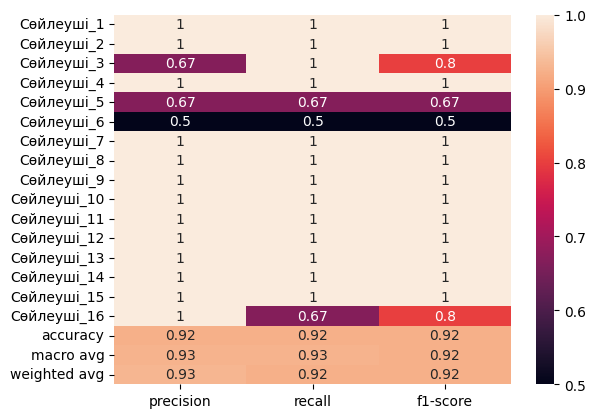

In [14]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


class_report = classification_report(y_test, y_pred, labels=[i for i in range(0, 16)],
                                   target_names=[f'Сөйлеуші_{i+1}' for i in range(0, 16)],
                                   output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

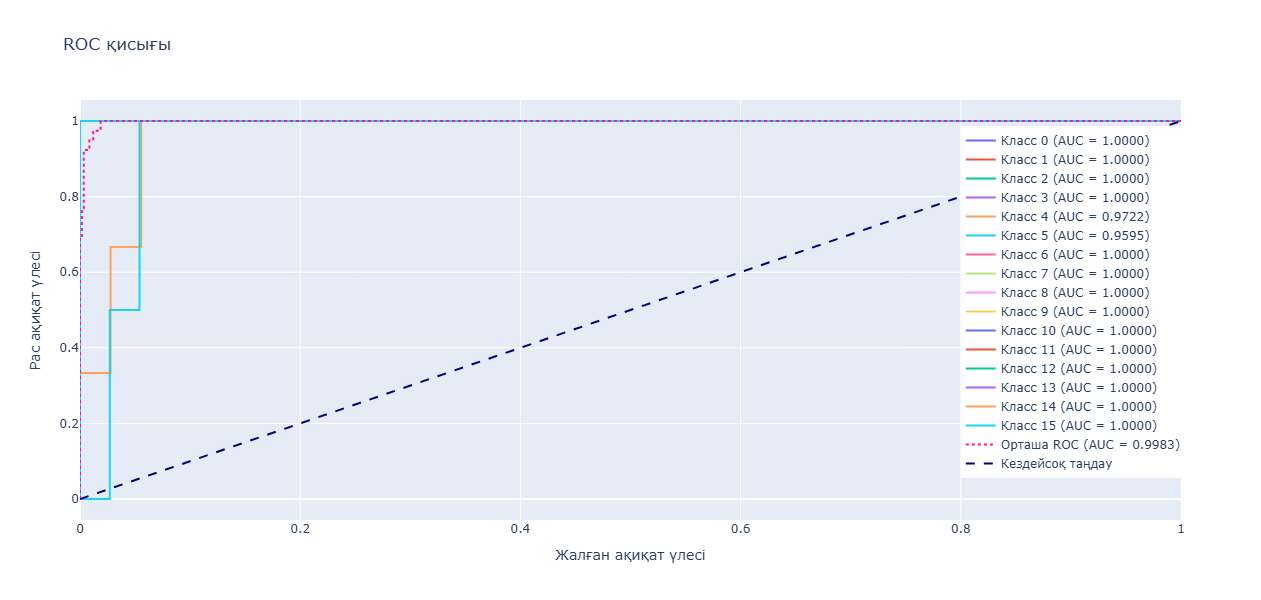

In [33]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=16)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(16):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fig = go.Figure()
colors = px.colors.qualitative.Plotly
for i in range(16):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Класс {i+1} (AUC = {roc_auc[i]:.4f})', line=dict(color=colors[i % len(colors)])))
fig.add_trace(go.Scatter(x=fpr["micro"], y=tpr["micro"], mode='lines', name=f'Орташа ROC (AUC = {roc_auc["micro"]:.4f})', line=dict(color='deeppink', dash='dot')))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Кездейсоқ таңдау', line=dict(color='navy', dash='dash')))
fig.update_layout(
    title='ROC қисығы',
    xaxis_title='Жалған ақиқат үлесі',
    yaxis_title='Рас ақиқат үлесі',
    showlegend=True,
    legend=dict(x=0.8, y=0.1),
    width=1100,
    height=600
)
fig.show()

In [34]:
FP = np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)
FN = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

FAR = FP / (FP + TN)
FRR = FN / (FN + TP)

print(f'Орташа FAR: {FAR.mean()}')
print(f'Орташа FRR: {FRR.mean()}')

Орташа FAR: 0.00511448948948949
Орташа FRR: 0.07291666666666666


In [77]:
intensity = 0.026
X_noise, y_noise, scaler_noise, SNR = prepare_data(Soileushiler, ip.F_dis, ip.win_len, ip.hop_len, ip.n_mfcc, ip.mfcc_frame, noised=True, intensity=intensity)
X_noise_train, X_noise_test, y_noise_train, y_noise_test = train_test_split(X_noise, y_noise, test_size=0.2, stratify=y, random_state=42)
print(f"SNR, шу интенсивтілігі {intensity} = {SNR}")

SNR, шу интенсивтілігі 0.026 = 24.49808223579158


In [78]:
test_loss_noise, test_accuracy_noise = best_model.evaluate(X_noise_test, y_test)
print(f'Тестілік жоғалтулар (шу бар сигнал): {test_loss_noise}')
print(f'Тестілік дәлдік (шу бар сигнал): {test_accuracy_noise}')

2/2 [==============================] - 0s 7ms/step - loss: 2.1721 - accuracy: 0.6667
Тестілік жоғалтулар (шу бар сигнал): 2.172117233276367
Тестілік дәлдік (шу бар сигнал): 0.6666666865348816


2/2 [==============================] - 0s 9ms/step


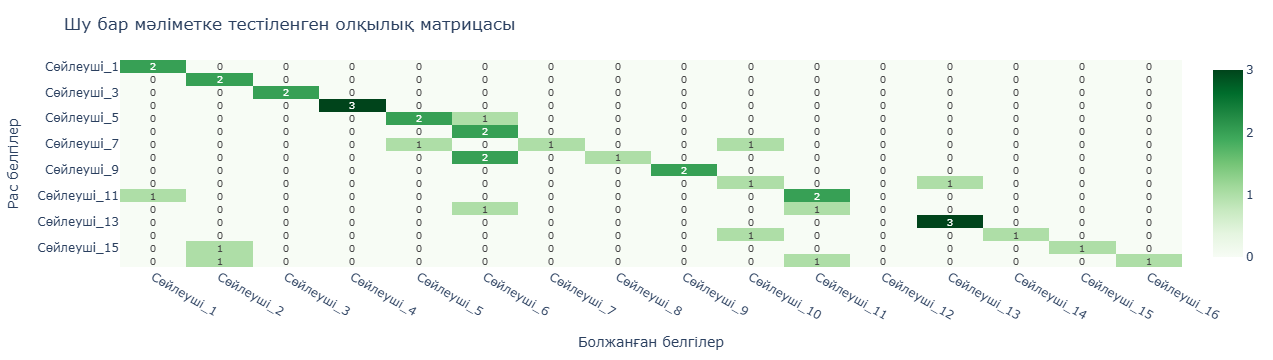

In [79]:
y_pred_noisy = best_model.predict(X_noise_test)
y_pred_noisy_max = np.argmax(y_pred_noisy, axis=1)

all_labels = list(range(16))

conf_matrix_noisy = confusion_matrix(y_test, y_pred_noisy_max, labels=all_labels)




xlabels = [f'Сөйлеуші_{i+1}' for i in range(0, 16)]

fig = px.imshow(conf_matrix_noisy, x=xlabels, y=xlabels, text_auto='.d', aspect='auto', color_continuous_scale='Greens',\
               labels=dict(x='Болжанған белгілер', y='Рас белгілер'))
fig.update_layout(title='Шу бар мәліметке тестіленген олқылық матрицасы')
fig.show()

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

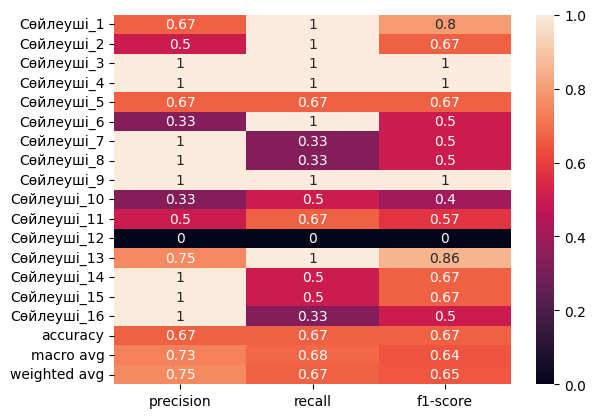

In [80]:
class_report_noisy = classification_report(y_test, y_pred_noisy_max, labels=all_labels, target_names=[f'Сөйлеуші_{i+1}' for i in all_labels], output_dict=True)
sns.heatmap(pd.DataFrame(class_report_noisy).iloc[:-1, :].T, annot=True)

In [81]:
FP_noise = np.sum(conf_matrix_noisy, axis=0) - np.diag(conf_matrix_noisy)
FN_noise = np.sum(conf_matrix_noisy, axis=1) - np.diag(conf_matrix_noisy)
TP_noise = np.diag(conf_matrix_noisy)
TN_noise = conf_matrix_noisy.sum() - (FP_noise + FN_noise + TP_noise)

FAR_noise = FP_noise / (FP_noise + TN_noise)
FRR_noise = FN_noise / (FN_noise + TP_noise)

print(f'Шу бар мәліметтің орташа FAR: {FAR_noise.mean()}')
print(f'Шу бар мәліметтің орташа FRR: {FRR_noise.mean()}')

Шу бар мәліметтің орташа FAR: 0.022147147147147148
Шу бар мәліметтің орташа FRR: 0.32291666666666663


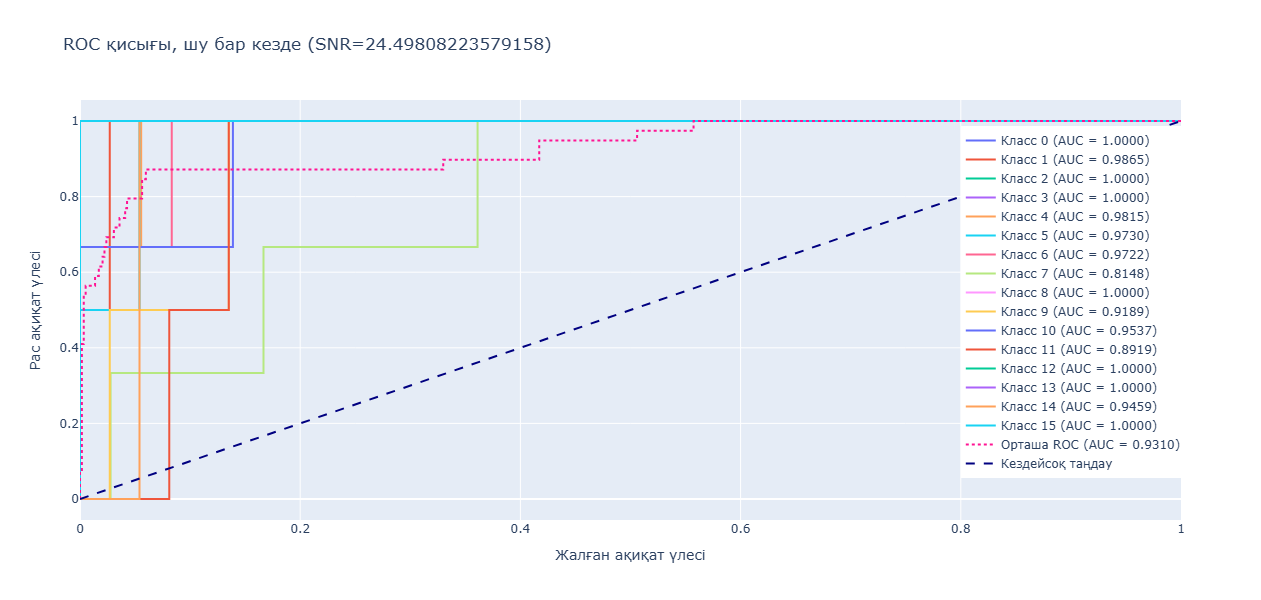

In [82]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(16):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_noisy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred_noisy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fig = go.Figure()
colors = px.colors.qualitative.Plotly
for i in range(16):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Класс {i+1} (AUC = {roc_auc[i]:.4f})', line=dict(color=colors[i % len(colors)])))
fig.add_trace(go.Scatter(x=fpr["micro"], y=tpr["micro"], mode='lines', name=f'Орташа ROC (AUC = {roc_auc["micro"]:.4f})', line=dict(color='deeppink', dash='dot')))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Кездейсоқ таңдау', line=dict(color='navy', dash='dash')))
fig.update_layout(
    title=f'ROC қисығы, шу бар кезде (SNR={SNR})',
    xaxis_title='Жалған ақиқат үлесі',
    yaxis_title='Рас ақиқат үлесі',
    showlegend=True,
    legend=dict(x=0.8, y=0.1),
    width=1100,
    height=600
)
fig.show()

In [57]:
best_model.save('Soileushi_model_CNN.keras')

import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']